# Reduced Order Modeling Quantum-DMD script 
Using Quadratic Unconstrainted Binary Optimization (QUBO) iteratively to advance a linearized system identified from Dynamic Mode Decomposition (DMD) to build a Reduced-order Model (ROM) for flow over a 2D cylinder <br>
Code associated w/ arXiv paper: https://arxiv.org/abs/2306.08087 <br>
Link to visualize data: https://www.youtube.com/watch?v=M2PqI2JD2jo

In [1]:
# import necessary packages
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import qiskit

## Define inputs to the model

In [2]:
# user-define inputs
num_modes = 5 # dimensionality of ROM; max is r = 8
precision = 2 # this is d in (A^d)*q=b system

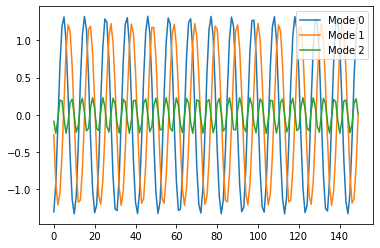

In [3]:
# grab some data: POD mode coefficients for flow over a 2D circular cylinder
snapshot_data = np.load('./Data/Limit_Cycle_Unscaled.npy')

# plot raw dataset
plt.figure()
plt.plot(snapshot_data[0,:],label='Mode 0')
plt.plot(snapshot_data[1,:],label='Mode 1')
plt.plot(snapshot_data[2,:],label='Mode 2')
plt.legend()
plt.show()

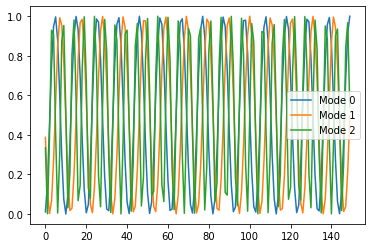

In [4]:
# data formatting
scaler = MinMaxScaler()
snapshot_data = scaler.fit_transform(snapshot_data.T).T

# plot scaled POD mode coefficients
plt.figure()
plt.plot(snapshot_data[0,:],label='Mode 0')
plt.plot(snapshot_data[1,:],label='Mode 1')
plt.plot(snapshot_data[2,:],label='Mode 2')
plt.legend()
plt.show()

## Learn an implicit linear operator: classical DMD

In [5]:
# identify DMD operator 
Xmat = snapshot_data[:num_modes,:-1]
Ymat = snapshot_data[:num_modes,1:]
A_dmd = np.matmul(Ymat,np.transpose(Xmat))
A_dmd = np.matmul(A_dmd,np.linalg.inv(np.matmul(Xmat,np.transpose(Xmat)))) # scaling
Astar = np.matmul(np.linalg.inv(np.matmul(A_dmd.T,A_dmd)),A_dmd.T) # reduced-space

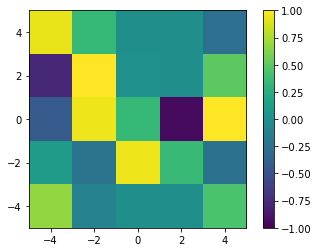

In [6]:
plt.figure()
plt.imshow(Astar,extent=[-num_modes,num_modes,-num_modes,num_modes],vmin=-1,vmax=1)
plt.colorbar()
plt.show()

### Check for non-QUBO based evolution

In [7]:
Atemp = np.linalg.inv(np.matmul(Astar.T,Astar))

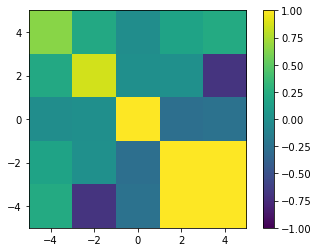

In [8]:
# DMD matrix for quantum-ROM
plt.figure()
plt.imshow(Atemp,extent=[-num_modes,num_modes,-num_modes,num_modes],vmin=-1,vmax=1)
plt.colorbar()
plt.show()

### Predict evolution of state using DMD

In [9]:
x_implicit_true = []
b = snapshot_data[:num_modes,0].reshape(-1,1)
max_time = 10 # number of timesteps for forecasting

# utilize DMD to obtain state predictions 
for time in range(max_time):
    x_nq = np.matmul(Atemp,np.matmul(Astar.T,b))
    x_implicit_true.append(x_nq)
    b = x_nq[:,0].reshape(-1,1)
    
x_true = snapshot_data[:num_modes,1:max_time+1]
x_implicit_true = np.asarray(x_implicit_true) # classical DMD prediction

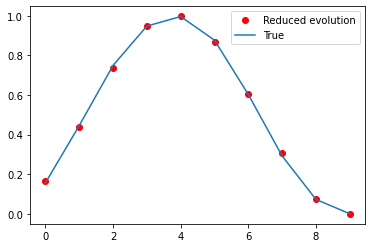

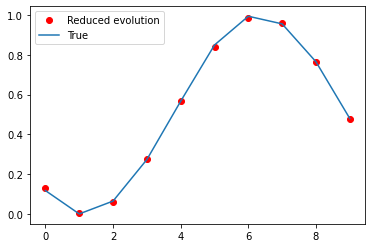

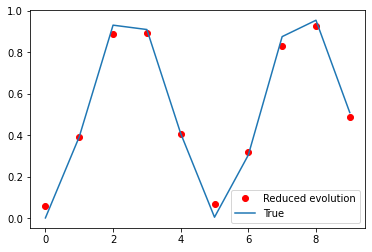

In [10]:
# plot classical DMD results

mode_num = 0
plt.figure()
plt.plot(x_implicit_true[:,mode_num,0],'ro',label='Reduced evolution')
plt.plot(x_true[mode_num,:],label='True')
plt.legend()
plt.show()

mode_num = 1
plt.figure()
plt.plot(x_implicit_true[:,mode_num,0],'ro',label='Reduced evolution')
plt.plot(x_true[mode_num,:],label='True')
plt.legend()
plt.show()

mode_num = 2
plt.figure()
plt.plot(x_implicit_true[:,mode_num,0],'ro',label='Reduced evolution')
plt.plot(x_true[mode_num,:],label='True')
plt.legend()
plt.show()

### Check for QUBO based evolution

#### Construction of conversion operation

In [11]:
def conversion_matrix(length,precision=8):
    '''
    length is the length of the vector that has to be 
    converted to binary
    precision is as the name suggests
    '''
    powers = 1+np.arange(precision)
    premult = 2.0**(1-powers)
    premult_mat = np.zeros(shape=(length,length*precision),dtype='float32')
    
    for i in range(length):
        premult_mat[i,i*precision:(i+1)*precision] = premult[:]
    
    return premult_mat

#### Precondition matrix with given precision definition; (A^d)q=b, where d = precision

In [12]:
premult_mat = conversion_matrix(length=num_modes,precision=precision)

In [13]:
print(Astar.shape)
print(premult_mat.shape) 

(5, 5)
(5, 10)


#### Construct the augmented A matrix

In [14]:
Ad = np.matmul(Astar,premult_mat)

In [15]:
Ad.shape

(5, 10)

In [16]:
import itertools

In [17]:
if precision <= 4:
    lst = list(itertools.product([0, 1], repeat=Astar.shape[1]*precision))
    for i in tqdm(range(len(lst))):
        assert np.sum(np.abs(np.matmul(Astar, np.matmul(premult_mat,lst[i]))-np.matmul(Ad, lst[i]))) <= 1e-9

100%|██████████| 1024/1024 [00:00<00:00, 63023.19it/s]


In [18]:
powers = 1+np.arange(precision)
premult = 2.0**(1-powers)

In [19]:
premult

array([1. , 0.5])

In [20]:
# import qiskit packages
import os.path, pkgutil
import qiskit_optimization.algorithms
pkgpath = os.path.dirname(qiskit_optimization.algorithms.__file__)
print([name for _, name, _ in pkgutil.iter_modules([pkgpath])])

['admm_optimizer', 'cobyla_optimizer', 'cplex_optimizer', 'goemans_williamson_optimizer', 'grover_optimizer', 'gurobi_optimizer', 'minimum_eigen_optimizer', 'multistart_optimizer', 'optimization_algorithm', 'recursive_minimum_eigen_optimizer', 'slsqp_optimizer', 'warm_start_qaoa_optimizer']


In [21]:
# import additional packages
from qiskit import BasicAer
from docplex.mp.model import Model
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import NumPyMinimumEigensolver, VQE, QAOA
from qiskit.utils import algorithm_globals

In [22]:
algorithm_globals.massive=True # needed for precision > 3

In [23]:
# binary conversion
vj = np.zeros(shape=(Ad.shape[-1]),dtype='float32')
wjk = np.zeros(shape=(Ad.shape[-1],Ad.shape[-1]),dtype='float32')
for j in range(Ad.shape[-1]):
    for k in range(Ad.shape[-1]):
        wjk[j,k] = 2.0*np.sum(Ad[:,j]*Ad[:,k])

In [24]:
# define method
exact_method = NumPyMinimumEigensolver()

### Solve for QUBO predictions on POD mode coefficients

In [25]:
b = snapshot_data[:num_modes,0].reshape(-1,1)
x_qubo = []

for time in range(max_time):
    print('Starting iteration at time:',time)
    
    for j in range(Ad.shape[-1]):
        vj[j] = np.sum(Ad[:,j]*Ad[:,j] - 2.0*Ad[:,j]*b[:,0])
        
    W = np.triu(wjk) - np.diag(np.diag(wjk))
    
    best_objective = 0.0
    max_inner_iter = 10
    stop_iter = 0
    best_qubo_result = None
    
    qp = QuadraticProgram()
    for i in range(Ad.shape[-1]):
        qp.binary_var(str(i))
    qp.objective.quadratic = W
    qp.objective.linear = vj
    exact = MinimumEigenOptimizer(exact_method)   # using QAOA
    exact_result = exact.solve(qp)
    result_obj = np.matmul(np.matmul(exact_result.x, W), exact_result.x)+ np.dot(vj,exact_result.x)
    qubo_result = np.matmul(premult_mat,exact_result.x)
        
    x_qubo.append(qubo_result)
    b = qubo_result[:].reshape(-1,1)
    
x_qubo = np.asarray(x_qubo)

Starting iteration at time: 0
Starting iteration at time: 1
Starting iteration at time: 2
Starting iteration at time: 3
Starting iteration at time: 4
Starting iteration at time: 5
Starting iteration at time: 6
Starting iteration at time: 7
Starting iteration at time: 8
Starting iteration at time: 9


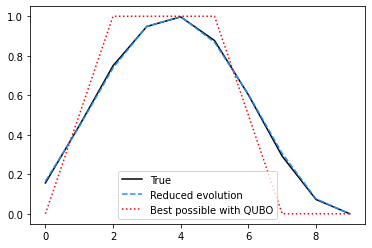

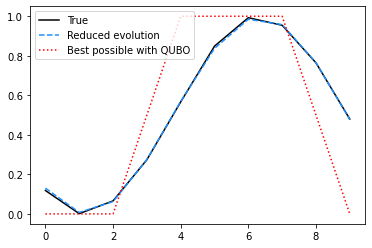

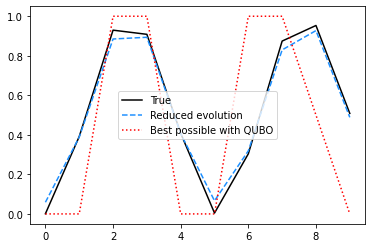

In [26]:
# plot QUBO results

mode_num = 0
plt.figure()
plt.plot(x_true[mode_num,:],label='True',color='k') # true mode coefficients
plt.plot(x_implicit_true[:,mode_num,0],label='Reduced evolution',color='dodgerblue',linestyle='--') # DMD prediction
plt.plot(x_qubo[:,mode_num],label='Best possible with QUBO',color='r',linestyle=':') # QUBO prediction
plt.legend()
plt.show()

mode_num = 1
plt.figure()
plt.plot(x_true[mode_num,:],label='True',color='k')
plt.plot(x_implicit_true[:,mode_num,0],label='Reduced evolution',color='dodgerblue',linestyle='--')
plt.plot(x_qubo[:,mode_num],label='Best possible with QUBO',color='r',linestyle=':')
plt.legend()
plt.show()

mode_num = 2
plt.figure()
plt.plot(x_true[mode_num,:],label='True',color='k')
plt.plot(x_implicit_true[:,mode_num,0],label='Reduced evolution',color='dodgerblue',linestyle='--')
plt.plot(x_qubo[:,mode_num],label='Best possible with QUBO',color='r',linestyle=':')
plt.legend()
plt.show()

## QUBO using Qiskit QAOA

In [27]:
backend = Aer.get_backend('qasm_simulator')
qinstance = QuantumInstance(backend, seed_simulator=2, seed_transpiler=2)
qaoa_mes = QAOA(quantum_instance=qinstance)

#### QAOA prediction

In [28]:
b = snapshot_data[:num_modes,0].reshape(-1,1)
x_qubo_qaoa = []

for time in range(max_time):
    print('Starting iteration at time:',time)
    
    for j in range(Ad.shape[-1]):
        vj[j] = np.sum(Ad[:,j]*Ad[:,j] - 2.0*Ad[:,j]*b[:,0])
        
    W = np.triu(wjk) - np.diag(np.diag(wjk))
    
    best_objective = 0.0
    max_inner_iter = 10
    stop_iter = 0
    best_qubo_result = None
    
    for inner in tqdm(range(5)):
        qp = QuadraticProgram()
        for i in range(Ad.shape[-1]):
            qp.binary_var(str(i))
        qp.objective.quadratic = W
        qp.objective.linear = vj
        qaoa = MinimumEigenOptimizer(qaoa_mes)   # using QAOA
        qaoa_result = qaoa.solve(qp)
        
        result_obj = np.matmul(np.matmul(qaoa_result.x, W), qaoa_result.x)+ np.dot(vj,qaoa_result.x)
        
        if result_obj < best_objective:
            best_objective = result_obj
            stop_iter = 0
            best_qubo_result = np.matmul(premult_mat,qaoa_result.x)
        else:
            stop_iter+=1
            
        if stop_iter == max_inner_iter:
            break
    
    x_qubo_qaoa.append(best_qubo_result)
    b = best_qubo_result[:].reshape(-1,1)
    
x_qubo_qaoa = np.asarray(x_qubo_qaoa)

Starting iteration at time: 0


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Starting iteration at time: 1


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


Starting iteration at time: 2


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Starting iteration at time: 3


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


Starting iteration at time: 4


100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


Starting iteration at time: 5


100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Starting iteration at time: 6


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


Starting iteration at time: 7


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Starting iteration at time: 8


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Starting iteration at time: 9


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


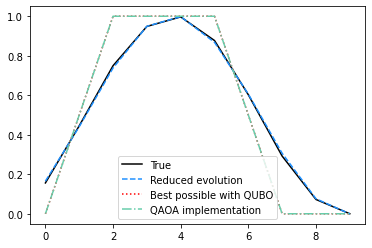

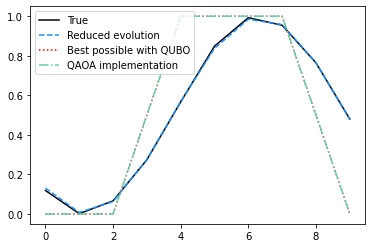

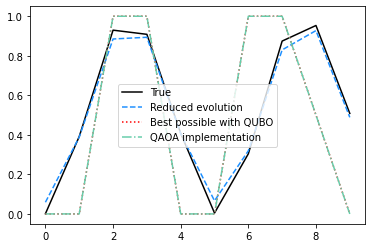

In [29]:
# plot QUBO-QAOA results

mode_num = 0
plt.figure()
plt.plot(x_true[mode_num,:],label='True',color='k') # true mode coefficients
plt.plot(x_implicit_true[:,mode_num,0],label='Reduced evolution',color='dodgerblue',linestyle='--') # DMD prediction
plt.plot(x_qubo[:,mode_num],label='Best possible with QUBO',color='r',linestyle=':') # QUBO prediction
plt.plot(x_qubo_qaoa[:,mode_num],label='QAOA implementation',color='mediumaquamarine',linestyle='-.') # QAOA prediction
plt.legend()
plt.show()

mode_num = 1
plt.figure()
plt.plot(x_true[mode_num,:],label='True',color='k')
plt.plot(x_implicit_true[:,mode_num,0],label='Reduced evolution',color='dodgerblue',linestyle='--')
plt.plot(x_qubo[:,mode_num],label='Best possible with QUBO',color='r',linestyle=':')
plt.plot(x_qubo_qaoa[:,mode_num],label='QAOA implementation',color='mediumaquamarine',linestyle='-.')
plt.legend()
plt.show()

mode_num = 2
plt.figure()
plt.plot(x_true[mode_num,:],label='True',color='k')
plt.plot(x_implicit_true[:,mode_num,0],label='Reduced evolution',color='dodgerblue',linestyle='--')
plt.plot(x_qubo[:,mode_num],label='Best possible with QUBO',color='r',linestyle=':')
plt.plot(x_qubo_qaoa[:,mode_num],label='QAOA implementation',color='mediumaquamarine',linestyle='-.')
plt.legend()
plt.show()